This is a generic script for finetuning ViLT model for VQA tasks
Simply format your data as per the requirements below and this should work.

## Data format
* the images (stored in a single folder)
* the questions (stored in a JSON) -- with following
* the annotations (stored in a JSON) a.k.a. the answers to the questions.

Refer to https://github.com/multimodal/multimodal/blob/master/test/data/vqa2/val/v2_OpenEnded_mscoco_val2014_questions.json for a sample of how question json file should look like.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.5 MB/s eta 0:00:00


This piece of code converts data in VLQAv1 into desired format. If multiple images are there, it automatically merges them into one.

In [ ]:
prefix = 'blocksworld'

In [ ]:
from PIL import Image
import os

os.chdir('/content')

def mergeim(impath1,impath2):
  if impath1.endswith(".jpg"):
    postfix = ".jpg"
  elif impath1.endswith(".png"):
    postfix = ".png"
  else:
    print("no jpg or png file supplied")
  newname = 'Merged_'+impath1.split("/")[-1].rstrip(postfix) + "#"+ impath2.split("/")[-1].rstrip(postfix) + postfix
  #print(newname)
  image1 = Image.open(impath1)
  image2 = Image.open(impath2)
  image1_size = image1.size
  image2_size = image2.size
  new_image = Image.new('RGB',(2*image1_size[0], image1_size[1]), (250,250,250))
  new_image.paste(image1,(0,0))
  new_image.paste(image2,(image1_size[0],0))
  new_image.save("./images/"+newname)
  #new_image.show()
  return "./images/"+newname

mergeim('./images/BW_1_0.jpg','./images/BW_1_1.jpg')

'./images/Merged_BW_1_0#BW_1_1.jpg'

In [ ]:
#!rm /content/blocksworld_truncated_viltft.jsonl

import json
import ast

dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "mscoco", "license": {}, "data_subtype": prefix,
    "questions": [] }

with open('/content/'+prefix+'.jsonl') as f:
  data = f.readlines()
  print(len(data))
  for i in data:
    ijson = json.loads(i)
    imlist = ast.literal_eval(ijson['images'])
    anslist = [str(i) for i in ast.literal_eval(ijson['answer_choices'])]
    if len(imlist) == 2:
      mpath = mergeim(imlist[0], imlist[1])
    dumpdict['questions'].append( { "image_id": mpath, "question": ijson['question']+" "+ijson['passage'], "question_id": ijson['qid'], "answer_choices": anslist, "answer_id": int(ijson['answer']) } )

with open('/content/'+prefix+'_viltft.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

print(dumpdict)

250
{'info': {}, 'task_type': 'Open-Ended', 'data_type': 'mscoco', 'license': {}, 'data_subtype': 'blocksworld_truncated', 'questions': [{'image_id': './images/Merged_BW_1_0#BW_1_1.jpg', 'question': 'In how many moves one can convert left image into right image? Blocks can be moved (i) if there is no other block on it (ii) only one block can be moved at a time (iii) block can be moved OnTable, OutOfTable or on any other block.', 'question_id': 0, 'answer_choices': ['1', '5', '2', '3'], 'answer_id': 0}, {'image_id': './images/Merged_BW_2_0#BW_2_1.jpg', 'question': 'In how many moves one can convert left image into right image? Blocks can be moved (i) if there is no other block on it (ii) only one block can be moved at a time (iii) block can be moved OnTable, OutOfTable or on any other block.', 'question_id': 1, 'answer_choices': ['4', '5', '2', '1'], 'answer_id': 3}, {'image_id': './images/Merged_BW_3_0#BW_3_1.jpg', 'question': 'In how many moves one can convert left image into right im

### Read questions

First, we read the questions.

In [ ]:
import json
f = open('/content/'+prefix+'_viltft.jsonl','r')
data_questions = json.load(f)
questions = data_questions['questions']

print(data_questions.keys())
print("Number of questions:", len(questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 250


That's quite a lot! Let's take a look at the first one:

In [ ]:
questions[0]

{'image_id': './images/Merged_BW_1_0#BW_1_1.jpg',
 'question': 'In how many moves one can convert left image into right image? Blocks can be moved (i) if there is no other block on it (ii) only one block can be moved at a time (iii) block can be moved OnTable, OutOfTable or on any other block.',
 'question_id': 0,
 'answer_choices': ['1', '5', '2', '3'],
 'answer_id': 0}

In [ ]:
from os import listdir
from os.path import isfile, join

# -- CHANGE THIS BASED ON WHERE IMAGES ARE STORED --
root = '/content/images'

file_names = [f for f in listdir(root) if isfile(join(root, f))]
print(file_names)
print(len(file_names))

['BW_33_1.jpg', 'BW_90_0.jpg', 'BW_75_1.jpg', 'BW_69_1.jpg', 'BW_91_1.jpg', 'BW_76_1.jpg', 'BW_61_1.jpg', 'BW_44_1.jpg', 'BW_48_1.jpg', 'BW_26_0.jpg', 'Merged_BW_69_0#BW_69_1.jpg', 'Merged_BW_86_0#BW_86_1.jpg', 'BW_87_0.jpg', 'Merged_BW_38_0#BW_38_1.jpg', 'BW_11_1.jpg', 'Merged_BW_96_0#BW_96_1.jpg', 'BW_91_0.jpg', 'Merged_BW_30_0#BW_30_1.jpg', 'BW_49_1.jpg', 'Merged_BW_99_0#BW_99_1.jpg', 'Merged_BW_10_0#BW_10_1.jpg', 'BW_24_1.jpg', 'BW_79_0.jpg', 'BW_57_0.jpg', 'BW_74_0.jpg', 'Merged_BW_91_0#BW_91_1.jpg', 'BW_44_0.jpg', 'BW_54_1.jpg', 'BW_68_1.jpg', 'BW_70_0.jpg', 'BW_93_1.jpg', 'Merged_BW_88_0#BW_88_1.jpg', 'Merged_BW_3_0#BW_3_1.jpg', 'Merged_BW_34_0#BW_34_1.jpg', 'Merged_BW_68_0#BW_68_1.jpg', 'Merged_BW_42_0#BW_42_1.jpg', 'BW_80_0.jpg', 'Merged_BW_67_0#BW_67_1.jpg', 'Merged_BW_80_0#BW_80_1.jpg', 'BW_89_1.jpg', 'BW_9_1.jpg', 'Merged_BW_56_0#BW_56_1.jpg', 'BW_65_1.jpg', 'BW_25_1.jpg', 'BW_43_0.jpg', 'BW_33_0.jpg', 'BW_6_0.jpg', 'BW_34_1.jpg', 'Merged_BW_20_0#BW_20_1.jpg', 'BW_10_1.jpg'

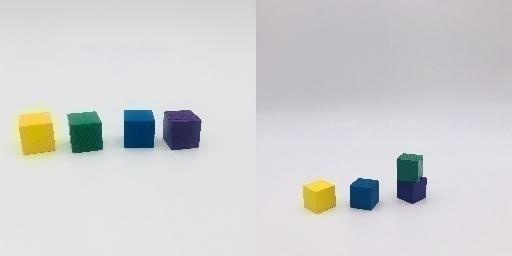

In [ ]:
from PIL import Image

path = questions[0]['image_id']
image = Image.open(path)
image

In [ ]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

## Create PyTorch dataset

Next, we create a regular [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We leverage `ViltProcessor` to prepare each image + text pair for the model, which will automatically:
* leverage `BertTokenizerFast` to tokenize the text and create `input_ids`, `attention_mask` and `token_type_ids`
* leverage `ViltFeatureExtractor` to resize + normalize the image and create `pixel_values` and `pixel_mask`.

Note that the docs of `ViltProcessor` can be found [here](https://huggingface.co/docs/transformers/master/en/model_doc/vilt#transformers.ViltProcessor).

We also add the labels. This is a PyTorch tensor of shape `(num_labels,)` that contains the soft encoded vector.

In [ ]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):

    def __init__(self, questions, processor): #annotations
        self.questions = questions
        #self.annotations = annotations
        self.processor = processor

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        # get image + text
        #annotation = self.annotations[idx]
        questions = self.questions[idx]
        #image = Image.open(id_to_filename[annotation['image_id']])
        image = Image.open(questions['image_id'])
        text = questions['question']
        #print(image)
        #print(text)
        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        # add labels
        #labels = questions['answer_choices'][questions['answer_id']] #annotation['labels']
        #scores = [1.0] #annotation['scores']
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        #print(len(questions['answer_choices']))
        targets = torch.zeros(len(questions['answer_choices']))
        targets[questions['answer_id']] = 1.0
        #print(targets)
        #for label, score in zip(labels, scores):
        #      targets[label] = score
        encoding["labels"] = targets
        #print(encoding)
        #print(labels)
        #print(scores)

        return encoding

In [ ]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

In [ ]:
# 4wT
#dataset = VQADataset(questions=questions[:100],processor=processor) ##annotations=annotations[:10],
# 4wS
dataset = VQADataset(questions=questions[100:150],processor=processor) ##annotations=annotations[:10],
# Bin

In [ ]:
dataset[1].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [ ]:
processor.decode(dataset[0]['input_ids'])

'[CLS] choose the correct order of moves i - iv to convert left image into right image. consider following 4 moves for the given pair of images : i. move ( red, outoftable ) [SEP]'

In [ ]:
labels = torch.nonzero(dataset[0]['labels']).squeeze().tolist()

## Define model

Here we define a `ViltForQuestionAnswering` model, with the weights of the body initialized from dandelin/vilt-b32-mlm, and a randomly initialized classification head. We also move it to the GPU, if it's available.

In [ ]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm", num_labels=4)
                                                 #len(config.id2label))
                                                 #id2label=config.id2label,
                                                 #label2id=config.label2id)
model.to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.3.bias', 'classifier.1.weight', 'classifier.0.weight', 'classifier.1.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  #print(pixel_values)
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  # create padded pixel values and corresponding pixel mask
  #encoding = processor.feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")

  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = torch.stack(pixel_values) #encoding['pixel_values']
  #batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)

Let's verify a batch:

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([1, 40])
attention_mask torch.Size([1, 40])
token_type_ids torch.Size([1, 40])
pixel_values torch.Size([1, 3, 320, 608])
labels torch.Size([1, 4])


## Train a model

Finally, let's train a model!

In [ ]:
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# -- CHANGE BASED ON HOW MANY EPOCHS YOU WANT TO RUN FOR
e = 5

model.train()
for epoch in range(e):  # loop over the dataset multiple times
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/50 [00:00<?, ?it/s]

Loss: 3.0689620971679688
Loss: 3.1118829250335693
Loss: 3.089102029800415
Loss: 2.6297624111175537
Loss: 2.6895055770874023
Loss: 2.51857852935791
Loss: 1.6954190731048584
Loss: 1.53492271900177
Loss: 1.3417366743087769
Loss: 3.4047164916992188
Loss: 2.359750747680664
Loss: 4.330535411834717
Loss: 2.277982234954834
Loss: 4.103263854980469
Loss: 3.8282504081726074
Loss: 3.482673168182373
Loss: 1.9048981666564941
Loss: 1.8055903911590576
Loss: 1.7269744873046875
Loss: 3.355116844177246
Loss: 3.1287267208099365
Loss: 2.892899513244629
Loss: 2.6846115589141846
Loss: 2.586251735687256
Loss: 2.4359707832336426
Loss: 1.5749385356903076
Loss: 3.5125155448913574
Loss: 2.4474434852600098
Loss: 1.8314117193222046
Loss: 3.575417995452881
Loss: 3.479635238647461
Loss: 2.2734031677246094
Loss: 3.187363624572754
Loss: 2.0157957077026367
Loss: 2.9856626987457275
Loss: 3.0618937015533447
Loss: 2.0607595443725586
Loss: 2.4785304069519043
Loss: 2.1646320819854736
Loss: 2.844784736633301
Loss: 2.834769487

  0%|          | 0/50 [00:00<?, ?it/s]

Loss: 2.5800352096557617
Loss: 2.560839891433716
Loss: 1.6323533058166504
Loss: 2.4657161235809326
Loss: 1.615034818649292
Loss: 2.3593332767486572
Loss: 1.6393762826919556
Loss: 1.5913704633712769
Loss: 1.5070011615753174
Loss: 3.301654100418091
Loss: 1.2809252738952637
Loss: 2.441789388656616
Loss: 1.1989006996154785
Loss: 3.133955717086792
Loss: 3.132040500640869
Loss: 3.56899356842041
Loss: 2.8787665367126465
Loss: 2.624701976776123
Loss: 1.2428375482559204
Loss: 3.354647159576416
Loss: 3.2635107040405273
Loss: 2.3388524055480957
Loss: 2.4487318992614746
Loss: 2.531256914138794
Loss: 2.295919418334961
Loss: 2.0614709854125977
Loss: 2.3366200923919678
Loss: 2.3419225215911865
Loss: 2.1517531871795654
Loss: 1.8537347316741943
Loss: 1.7332240343093872
Loss: 3.0163917541503906
Loss: 1.6177709102630615
Loss: 2.9560046195983887
Loss: 2.9182686805725098
Loss: 3.133754253387451
Loss: 3.0057291984558105
Loss: 3.0963354110717773
Loss: 2.4047443866729736
Loss: 2.953584671020508
Loss: 2.648709

  0%|          | 0/50 [00:00<?, ?it/s]

Loss: 1.8992663621902466
Loss: 2.319719076156616
Loss: 2.6676135063171387
Loss: 2.8703956604003906
Loss: 3.078274965286255
Loss: 1.790893793106079
Loss: 1.7642364501953125
Loss: 1.7746572494506836
Loss: 1.7576730251312256
Loss: 2.1680164337158203
Loss: 2.676412582397461
Loss: 1.9571142196655273
Loss: 2.5634095668792725
Loss: 1.3169162273406982
Loss: 1.6128122806549072
Loss: 2.635927438735962
Loss: 2.332552671432495
Loss: 2.532076358795166
Loss: 2.6777851581573486
Loss: 2.516796827316284
Loss: 2.381272554397583
Loss: 2.682041645050049
Loss: 1.5862255096435547
Loss: 4.691182613372803
Loss: 2.5823049545288086
Loss: 1.5716185569763184
Loss: 2.3936290740966797
Loss: 2.2647523880004883
Loss: 1.9796741008758545
Loss: 1.582384705543518
Loss: 2.0864133834838867
Loss: 2.1091535091400146
Loss: 2.0841071605682373
Loss: 2.917445659637451
Loss: 3.194061756134033
Loss: 1.918897032737732
Loss: 1.941428542137146
Loss: 1.8729510307312012
Loss: 2.7092604637145996
Loss: 3.427856206893921
Loss: 1.749678611

  0%|          | 0/50 [00:00<?, ?it/s]

Loss: 1.751276969909668
Loss: 2.6574482917785645
Loss: 2.7848563194274902
Loss: 2.276036024093628
Loss: 1.7255487442016602
Loss: 2.438162326812744
Loss: 2.0239548683166504
Loss: 2.3383607864379883
Loss: 2.505463123321533
Loss: 2.032442092895508
Loss: 2.136565923690796
Loss: 2.481750726699829
Loss: 2.1235568523406982
Loss: 2.018866777420044
Loss: 1.9783735275268555
Loss: 2.1569786071777344
Loss: 2.144038677215576
Loss: 2.5888586044311523
Loss: 1.7471429109573364
Loss: 1.8123003244400024
Loss: 2.5018622875213623
Loss: 1.7528936862945557
Loss: 1.5698834657669067
Loss: 1.694310188293457
Loss: 1.5627003908157349
Loss: 3.8773083686828613
Loss: 2.7366819381713867
Loss: 1.5309313535690308
Loss: 2.0604307651519775
Loss: 1.8463996648788452
Loss: 3.1905596256256104
Loss: 2.2492640018463135
Loss: 1.4203797578811646
Loss: 2.5664262771606445
Loss: 2.1956169605255127
Loss: 2.682614326477051
Loss: 2.0665171146392822
Loss: 2.3632407188415527
Loss: 2.7422587871551514
Loss: 2.1196844577789307
Loss: 2.144

  0%|          | 0/50 [00:00<?, ?it/s]

Loss: 1.9493757486343384
Loss: 2.0844669342041016
Loss: 1.817322015762329
Loss: 2.6997294425964355
Loss: 1.9146332740783691
Loss: 2.5406618118286133
Loss: 2.1832034587860107
Loss: 2.5004873275756836
Loss: 1.714529037475586
Loss: 2.0123775005340576
Loss: 2.096289873123169
Loss: 1.5520037412643433
Loss: 2.1301636695861816
Loss: 3.0225162506103516
Loss: 2.1014506816864014
Loss: 3.0575902462005615
Loss: 3.0540475845336914
Loss: 2.76888370513916
Loss: 2.252608299255371
Loss: 2.433241367340088
Loss: 2.776512861251831
Loss: 1.5449525117874146
Loss: 1.474355936050415
Loss: 1.3868080377578735
Loss: 1.680931568145752
Loss: 1.2783191204071045
Loss: 1.8849964141845703
Loss: 1.0217812061309814
Loss: 1.7777957916259766
Loss: 2.8388702869415283
Loss: 2.561091423034668
Loss: 2.3065037727355957
Loss: 1.1546351909637451
Loss: 2.814534902572632
Loss: 1.617103099822998
Loss: 4.19929313659668
Loss: 2.8218770027160645
Loss: 1.0223016738891602
Loss: 2.4302992820739746
Loss: 2.46894907951355
Loss: 3.925879716

## Inference

Let's verify whether the model has actually learned something:

# Single Instance Inference

In [ ]:
exid = 1
example = dataset[exid]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])


In [ ]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

In [ ]:
logits = outputs.logits
predicted_class = logits.argmax(-1).item()
print("Predicted answer:", predicted_class)
print("Ground-truth answer:", dataset[exid]['labels'].argmax(-1).item())

Predicted answer: 0
Ground-truth answer: 3


# Batch Inference

In [ ]:
import csv
tasktype = "4ws"
filprefix = prefix+"_"+tasktype

# Accuracy of 4wS blocksworld data truncated - finetuned by ViLT
count = 0
st = 0
end = 49
with open(filprefix+'.csv', 'w+') as k:
  spamwriter = csv.writer(k)
  spamwriter.writerow(["qid","pred_ans","gt_ans","correctness"])
  for exid in range(st,end+1):
    correctness = 0
    example = dataset[exid]
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
    outputs = model(**example)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    gtclass = dataset[exid]['labels'].argmax(-1).item()
    if gtclass==predicted_class:
      count+=1
      correctness = 1
    print([exid,predicted_class, gtclass,correctness])
    spamwriter.writerow([exid,predicted_class, gtclass,correctness])
acc = count*100/(end-st+1)

print(count)
print(end-st+1)
print(acc)

[0, 0, 2, 0]
[1, 2, 3, 0]
[2, 0, 0, 1]
[3, 1, 1, 1]
[4, 1, 1, 1]
[5, 1, 0, 0]
[6, 0, 0, 1]
[7, 0, 1, 0]
[8, 2, 2, 1]
[9, 2, 3, 0]
[10, 1, 1, 1]
[11, 2, 2, 1]
[12, 0, 1, 0]
[13, 1, 1, 1]
[14, 0, 0, 1]
[15, 1, 3, 0]
[16, 2, 2, 1]
[17, 1, 3, 0]
[18, 0, 0, 1]
[19, 2, 1, 0]
[20, 1, 0, 0]
[21, 2, 2, 1]
[22, 2, 0, 0]
[23, 2, 3, 0]
[24, 2, 3, 0]
[25, 2, 3, 0]
[26, 2, 3, 0]
[27, 2, 2, 1]
[28, 0, 0, 1]
[29, 2, 0, 0]
[30, 0, 1, 0]
[31, 2, 2, 1]
[32, 2, 0, 0]
[33, 1, 0, 0]
[34, 0, 0, 1]
[35, 2, 2, 1]
[36, 0, 1, 0]
[37, 0, 0, 1]
[38, 2, 3, 0]
[39, 0, 0, 1]
[40, 1, 2, 0]
[41, 2, 3, 0]
[42, 1, 1, 1]
[43, 0, 1, 0]
[44, 0, 2, 0]
[45, 2, 1, 0]
[46, 2, 2, 1]
[47, 0, 0, 1]
[48, 0, 1, 0]
[49, 2, 3, 0]
22
50
44.0


In [ ]:
import csv
tasktype = "4ws"
filprefix = prefix+"_"+tasktype

# Accuracy of 4wS blocksworld data original - finetuned by ViLT
count = 0
st = 0
end = 49
with open(filprefix+'.csv', 'w+') as k:
  spamwriter = csv.writer(k)
  spamwriter.writerow(["qid","pred_ans","gt_ans","correctness"])
  for exid in range(st,end+1):
    correctness = 0
    example = dataset[exid]
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
    outputs = model(**example)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    gtclass = dataset[exid]['labels'].argmax(-1).item()
    if gtclass==predicted_class:
      count+=1
      correctness = 1
    print([exid,predicted_class, gtclass,correctness])
    spamwriter.writerow([exid,predicted_class, gtclass,correctness])
acc = count*100/(end-st+1)

print(count)
print(end-st+1)
print(acc)

[0, 0, 2, 0]
[1, 0, 3, 0]
[2, 0, 0, 1]
[3, 0, 1, 0]
[4, 0, 1, 0]
[5, 0, 0, 1]
[6, 0, 0, 1]
[7, 0, 1, 0]
[8, 0, 2, 0]
[9, 0, 3, 0]
[10, 0, 1, 0]
[11, 0, 2, 0]
[12, 0, 1, 0]
[13, 0, 1, 0]
[14, 0, 0, 1]
[15, 0, 3, 0]
[16, 0, 2, 0]
[17, 0, 3, 0]
[18, 0, 0, 1]
[19, 0, 1, 0]
[20, 0, 0, 1]
[21, 0, 2, 0]
[22, 0, 0, 1]
[23, 0, 3, 0]
[24, 0, 3, 0]
[25, 0, 3, 0]
[26, 0, 3, 0]
[27, 0, 2, 0]
[28, 0, 0, 1]
[29, 0, 0, 1]
[30, 0, 1, 0]
[31, 0, 2, 0]
[32, 0, 0, 1]
[33, 0, 0, 1]
[34, 0, 0, 1]
[35, 0, 2, 0]
[36, 0, 1, 0]
[37, 0, 0, 1]
[38, 0, 3, 0]
[39, 0, 0, 1]
[40, 0, 2, 0]
[41, 0, 3, 0]
[42, 0, 1, 0]
[43, 0, 1, 0]
[44, 0, 2, 0]
[45, 0, 1, 0]
[46, 0, 2, 0]
[47, 0, 0, 1]
[48, 0, 1, 0]
[49, 0, 3, 0]
15
50
30.0
